# Chapter 11: Training Neural Networks

This chapter will deal with some of the issues that one has to face when training ANNs. Some the issues include:

1. The Vanishing or Exploding Gradient Problem
2. When there is not enough training data or it is expensive to label training data
3. Training may be too slow
4. When overfitting might be a huge issue and there is not enough training data or it is too noisy.

We will cover solutions to each of these issues, in the chapter.

## 1. Vanishing Gradient and Exploding Gradient Problem

This issue occurs during training, when during the backpropagation stage, which goes from outout layer to input layer, and the algorithm computes the gradients along the way. Once it has computed the gradient for the cost function,with repsect to each paramter, it updates the parameters with a gradient descent step, converging to a global minimum.

The gradients however, become smaller and smaller and the algorithm moves from output layer and input layer. This causes the layers closests to the input layer to be left unchanged. More specifically, the connection weights for the layers closest to the input layer are left unchanged, as the gradient is extremely close to zero, which leaves them with virtually no gradient steps to work with. Gradients can also grow larger and larger, which causes the loss to diverge. This is common in Recurrent NNs

The cause for this was the activation function used, and the initialization of the weight connections. When the logistic function is used, and the values are too large, the output would be saturated, meaning close to zero or one, where the gradient of the function there is every close to zero(The function is nearly a straight (horizontal) line at these points). So when the backpropagation kicks in, its got no gradients to work with.

### Glorot and He initialization 
A solution to this, would be to randomly initialize the weight connections using the Glorot initialization, LeCunn Initialization or the He Initialization. (for more in these please visit the book, Chapter )

Using the Glorot initialization, can speed up training considerably, and this led to the success of DNNs

The table below illustrates, the different types of initialization parameters for each activation function:

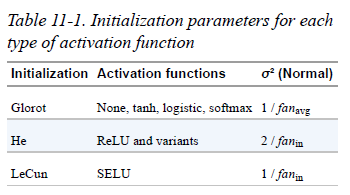


Keras, uses the glorot initialization as a default and you can change the initialization technique to he initialization technique when creating a dense layer, be specifying a kernel_initializer parameter by calling the `he_uniform` or `he_normal`
e.g code `Dense(units = 100, activation = "relu", kernel_initializer = "he_uniform")`

Another solution to the vanishing gradient/exploding gradient problem would be to use:

### Nonsaturating Activation Functions

One of the causes for vanishing gradient, was found to be the choice of activation function used in the hidden layers. The logistic function was very popular until, this issue was found. As a solution, the RELU activation function was used, and is still very popular. However the RELU function also has a drawback: Since the RELU function is zero for values that are negative, this caused some neurons to die, meaning that if the weighted sum resulted in a negative number, the output would be zero because of the RELU function.

As a counter measure to this, variants of the RELU function were explored, such as the Leaky RELU function, The Randomized Leaky RELU and the Parametric RELU function. All these variants work with a hyperparameter of alpha, which is the slope of the function(or the leak) for negative values. For Leaky RELU, one can pick a specific value of alpha, for randomized RELU, the alpha parameter is picked randomly, and finally for the PRU, alpha is hyperparameter that is learned during training. 

Another actvaition function used was ELU(Exponential Linear Unit). ELU, outperformed the RELU activation function and its variants. One drawback of the ELU function, is that it is slower to compute than the RELU activation function. It has a faster convergence rate but takes longer to compute due to the exponential function. Even during Test time, the ELU will be slower than RELU.

ELU is very similar to the RELU function,however, it does not go to zero of negative values. It also has non-zero gradients for negative values.

Another activation function to used would be the Scaled ELU, or SELU. This is a scaled variant of the ELU function. And what was found with this function, if a NN is built using Stacked Dense layers,and all the layers using the SELU function as their activation function, the Network would self-normalize(meaning during training, the output of each layer would preserve the mean of 0 and standard deviation of 1), which ultiately solves the vanishing gradient problem. However there are some condition to be met for the network to self-normalize. It must:

1. The input features must be standardized(have a mean of 0 and standard deviation of 1)
2. Every hidden layer's weights must be initialized using the `lecun_normal` initialization eg. Dense(...., kernel_initializer = "lecun_normal")
3. The network archetecture must be Sequential, meaing we cannot use the Custom Topologies or Sub class or the Functional API(Selu cannot be used with these)
4. All the hidden layers must be Dense, but self-normalization can also work for Convolutional NNs.

Generally, when choosing an activation fuunction, usually: SELU > ELU > Leaky RELU(variants) > RELU > tanh > Logistic Function.

If the network architecture, prohibits self-normalization, then best use ELU.

Code Examples:

- To use selu
`Dense(....., activation = "selu", kernel_initializer = "lecun_normal")`
- To use Leaky RElU:
To use the Leaky relu function, you have to create a layer after the layer you want to appply to:
`Dense(.....,kernel_initialzer = "he_normal")
 LeakyRELU(alpha = 0.3)`

Another way to beat the vanishing gradient is to use:
### Batch Normalization
Although the use of a kernel initialzer = "he_normal" and the activation function like ELU, solves the vanishing gradient at the beginning of training, there is no assurance, that the issue will appear during training. In order to avoid it, Batch Normalization is used.

The technique, involves adding an opertaion to the model, before or after the activation function of each hidden layer. The operation zero-centers and normalizes each input, scales it then shifts the result using two vectors: One vector for scaling and one for shifting. The operation will let the model learn, the optimum scale and then the mean for each layers inputs.

Sometimes, if Batch normalization is used, one does not have to scale the features using Standardization, since Batch Normalization does this. So Batch Normalization standardizes the inputs, rescales them and them shifts them.

To implement this in Keras, one simply adds a BatchNormalization layer, in which four parameters will be learned in each batch-normalised layer. Four Parameters: Output Scale vector, Output offset vector, will be learned during the backpropagation stage, and the final input mean vector and final input standard deviation vector will be estomated using an exponential moving average. 

Batch Normalization greatly reduces the vanishing gradient problem but also acts a regularizer, which will stop the need to use regularization techniques like dropout. 

Batch Normalization does have a runtime penalty though, due to the extra computations that need to be done.

Example Codes on how to implement BatchNormalization.

Create a model using the Sequential API and add a BatchNormalization layer after each hidden layer
`model = Sequential()
model.add(Flatten(input_shape = [28,28]))
model.add(BatchNormalization())
model.add(Dense(units =100, activation = 'elu', kernel_initialzer = "he_normal")
model.add(BatchNormalization())
model.add(Dense(units.....))
model.add(BatchNormalization())
model.add(Dense(units = 10, activation = softmax))`

The four paramters of the batchNormalization layer are usually, included in the model summary, usually, previous layer paramters * 4 will be the parameters for the batchnormalization layer. Also they are non-trainable parameters.

BatchNormalization is often used after every hidden layer. (Will try this out and compare the results).

Another method to reduce vanishing gradient is:

### Gradient Clipping
Another method to use, when mitigating vanishing/exploing gradient is to clip the gradients,during backpropagation stage,below a set threshold. The gradients should not exceed the set threshold, which is usually a range of values.This technique is usually used in Recurrent NNs, as BatchNormalization is tricky to implement in RNNs

To implement this, we specify a `clip_value` or `clipnorm` argument when creating an optimizer.

example:

`from tensorflow.keras.optimizers import SGD
optimizer = SGD(clip_value = 1.0)`

This is clip the gradients between -1.0 and 1.0. The clip_value hyperparameter can change the orientation of the gradient vector. So another way would be to specify a `clipnorm` value, which will preserve the gradient vector orientation, but still setting them within a threshold. 

One can combine these clipping methods or experiment with them separately to see which one works best. RECALL THOUGH, THIS METHOD IS USED FOR RECURRENT NEURAL NETWORKS.
















## 2. Using Pretrained Layers

It generally not a good idea to train a very large Deep Learning Model from scratch. Rather find, an existing neural network that accomplishes a similar task. This is known as **`transfer learning`**. This approach will improve the training time, but also it helps when there is not alot of training data available.

Suppose there is a prebuilt model, that can classify 1000 different classes. Ranging from animals, to everyday objects such as types of vehicles. Now, suppose, your task is to build a model that can classify the types of vehicles. What one, can do, would be to take the lower layers of the pretrained model, and make the weights/parameters fixed, and then add trainable layers at the top. 

This can be seen in the image below:

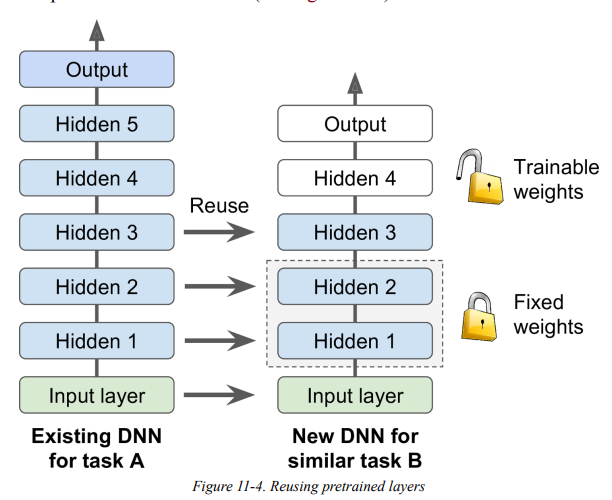

The tasks are similar and even overlap, so it would be a good idea to re-use some of the initial layers of the pretrained model.

**NOTE:** **If the input pictures of your new task don’t have the same size as the ones used in the
original task, you will usually have to add a preprocessing step to resize them to the size
expected by the original model. More generally, transfer learning will work best when
the inputs have similar low-level features.**

The output layer of the pre-trained model should be replaced. In the same light, the upper-level layers of the pre-trained model are not as useful, as the low-level layers. This is because, the high-level features, that are needed, for a new task maybe significantly different from the original task.

As a **TIP:** **The more similar the tasks are, the more layers you want to reuse (starting with the
lower layers). For very similar tasks, try keeping all the hidden layers and just replacing
the output layer**

Layers can be re-used or not by freezing them. Essentially, making their weight to be unchanged during training.
The basic rule illustrated in the book is as follows:

1. Try Freezing all the pre-trained model layers (*reused layers*), train the model and see how it performs.

2. Then, you can try unfreezing the top or the first two hidden layers. Train the model again, and see if the performance changes. **The more training data you have, the more layers you can unfreeze**

3. It should also be noted, that the learning rate, should also be decreased, when unfreezing layers, so as to not change the fine-tuned weights too much.

4. If performance is still not satisfactory, then try dropping the top hidden layers and freezing all the remaining layers. Try train again. It is basically an iterative process, until the right number of unfreezed layers is found.

### Transfer learning using Keras

Lets see how transfer learning can be implemented using Keras. Suppose there is a task that you want to do, and there is a similar task, for which there is a pretrained model available. 

You will have to load that model, and then load it. However, there is one extra step that you can take to make sure training that does affect the pre-trained model, that is to clone the pre-trained model.

This is how this is done:

1. Load the model:

`model_A = keras.models.load_model("name_of_model.h5")`

2. Clone the model

`model_A_clone = model_A.clone_model()`

3. Get the weights of the cloned model

`model_A_clone.set_weights(model_A.get_weights())`

4. Now add the lower layers expect the output layer of the pre-trained model (*model_A*)

`model_B = keras.models.Sequential(model_A_clone.layers[:-1])`
`model_B.add(Dense(1, activation = "sigmmoid"))`

Cool, now we have loaded a pretrained model, and also added its architecture to the new model. Now to unfreeze or freeze layers. Once must change the `trainable` parameter of the layers to False(to Freeze) or to True(To Unfreeze). Then compile the model.

It shown in the code below how to do this:

`for layer in model_B.layers[:-1]:
     layer.trainable = False`
     
 `model_B.complile(loss="binary_crossentropy", optimizer="sgd",
 metrics=["accuracy"])`
 
 The above will freeze all the lower layers, and to unfreeze then, we do the following:
 
`for layer in model_B.layers[:-1]:
     layer.trainable = True`
     
 `model_B.complile(loss="binary_crossentropy", optimizer="sgd",
 metrics=["accuracy"])`
 
 **NOTE: You must always compile your model after you freeze or unfreeze layers.**
 
 It should be laso noted that transfer learning does not work well for small dense networks. This is because, small networks,     learn very few and very specific patterns, that might not be useful, for another task.
 
 Transfer Learning works well for Deep Convolutional Networks, where the lower layers, are used as feature detectors.
 
### Unsupervised Pretraining

When you have a complex task, there is no available pre-trained model and there is not sufficient labelled training data. Once approach is to use **`Unsupervised Pretraining`**. 

This can help, as you can gather unlabeled training data, and use unsupervised training method,to get patterns from the data. A practical example, would be to train an AutoEncoder or a General Adverserial Network, on the unlabelled training data, then use the lower level layers of the AutoEncoder or the low-level layers of the Discriminator of a General adverserial Network as the low-level layers to your model plus your own output layer tailored to the task at hand. Then train this using the small amount of labelled data.

This technique was first implemented by Geoffery Hinton, and is the reason why AutoEncoders work so well.

So Unsupervised Pretraining is a good option when you have a complex task to solve, no similar model you can reuse, and little labeled training data but plenty of unlabeled training data.

Back in the day, people would train DNN using a technique called *`greedy layer-wise pretraining`*. Here basically, you take one layer of AE or RBM(Restricted Boltzmann Machine),train it. Freeze this layer, add another one on top, and train again. Thus the process would repeat, as the lower level layers are frozen, and one would be technically, training a single layer at a time.

This is shown in the image below:

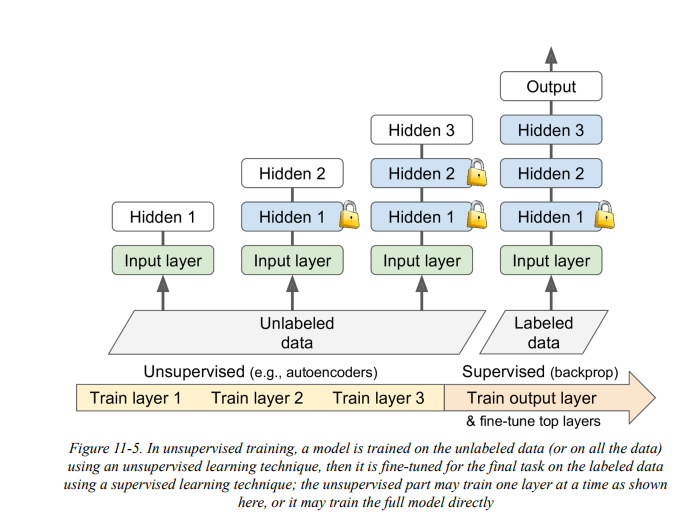

**Self-supervised learning** is when you automatically generate the labels from the data
itself, then you train a model on the resulting “labeled” dataset using supervised learning
techniques. Since this approach requires no human labeling whatsoever, it is best
classified as a form of unsupervised learning.

## 3. Optimizers

One of the parameters that can be changed, would be the type of optimizer is used. The book, goes rather in depth, with regards to the convergence speed, and convergence quality of the different optimizers in mathematical detail, which is beyond the scope of this notebook. However, below is a table that compares the convergence speed, and convergence quality of the different optimizers


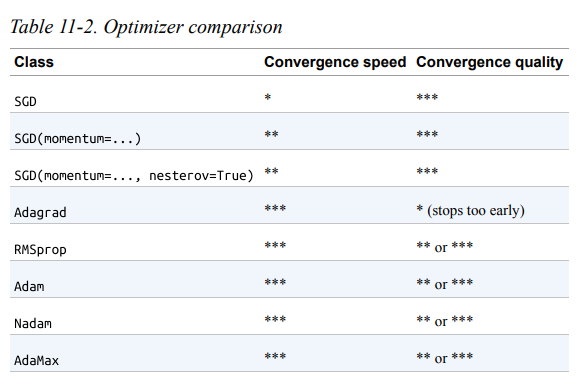

* means bad, ** means average and *** means good.

## 4. Scheduling the Learning Rate


It is vital to find a good learning rate. It cannot be set too high otherwise, the optimal global minimum can be overshoot,and training can diverge. Secondly, it cannot be too low, as training will take too long, even though it might converge to an optimum loss value. In addition to this, it cannot be set slightly too highor will make fast initial progress and then eventually flucuate about the optimum value. So there techniques that one can use to find the right  learning rate.

The image below shows how different learning rates affect the training process.

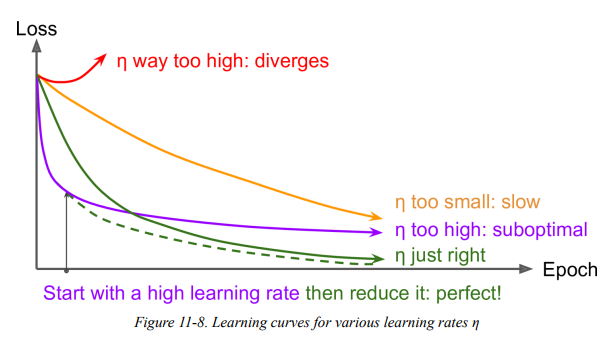



#### Techniques to find schedule the learning rate

One way to find a good learning rate, is to start-off by training the model for a few 100 epochs, all the while you are increasing the learning rate exponentially, from a small value to a large value. Then, you would look at the learning curve, and get the learning rate slightly lower than the one at which the learning curve shoots up. Then you can train the model again using the optimal lr.

The lr can also be changed while training commences.

###### The following are tchniques used to schedule learning-rates during training

1. **Power Scheduling**
   
   This technique involves,starting with a large learning-rate, and then decreasing it by a certain decay as training      commences.
   
   ```lr = lr0 / (1 + steps / s)**c```
    * Keras uses `c=1` and `s = 1 / decay`
    
   This can be done by giving the decay parameter in the optimizer a value as shown below:
   `optimizer = tf.keras.optimizer.SGD(lr=0.001, decay=1e-4)`
   
   

2. **Exponential Scheduling**
   
   This technique involves decreasing the learning rate gradually by a factor of 10 at every step.
   With Power Scheduling, the lr is reduced more slowly, but  with exponential scheduling, we slash the learning rate by 10.
   
   ```lr = lr0 * 0.1**(epoch / s)```
   
   We can do this by defining a function:
   
   `def exponential_decay(epoch):`
        `return 0.01*0.1(epoch/s)`
        
    If you want to hard the values of s and lr0, you can define a nested function:
    
    `def exponential_decay(lr0, s):
         def exponential_decay_function(epoch):
            return lr0*0.1(epoch/s)
        return exponential_decay_fn`
     
     Then create a variable of the function
     `exponential_decay_fn = exponential_decay(lr0=0.01, s=20)`
     
     This will be then used as a callback, using the LearningRateScheduler class
     
     `lr_scheduler= tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)`
     
     **Then you can call the fit method. Be sure to assign the number of epochs to a variable.**
     
     
3. **Performance Scheduling**
   For this technique, we measure the vallidation error every N steps, and then reduce the learing rate by a factor λ when the error stops dropping.
   
   In Keras we create an object  of the ReduceLROnPlateau class for performance scheduling and use it as a callback:
   
   `lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)`
   
   
4. **1Cycle Scheduling**
   This technique starts with initial learning rate lr0, and growing it linearly up to maximum lr for the first half of the training process. Then decreasing the learning-rate down to the initial lr during the second half of the training process.Finally,during the last few epochs, the learning rate is then decreased linearly by several orders of magnitude. The max lr is found using the method of finding the optimum lr, and the initial lr,is usually 10 times lower than the max lr.
   

**In general, the 1Cycle approach works best always**

Below is how one can implement it in code

In [1]:
K = keras.backend
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.lr, rate)

NameError: name 'keras' is not defined

In [ ]:
# Create an object of this class to be used as a CallBack
n_epochs = 25
onecycle = OneCycleScheduler(math.ceil(len(X_train) / batch_size) * n_epochs, max_rate=0.05)

#Note:
#Find out what the ceil function does.

### Code  for plotting the learning rate schedulesafter training

In [ ]:
# Power Scheduling
import math

learning_rate = 0.01
decay = 1e-4
batch_size = 32
n_steps_per_epoch = math.ceil(len(X_train) / batch_size)
epochs = np.arange(n_epochs)
lrs = learning_rate / (1 + decay * epochs * n_steps_per_epoch)

plt.plot(epochs, lrs,  "o-")
plt.axis([0, n_epochs - 1, 0, 0.01])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize=14)
plt.grid(True)
plt.show()

In [ ]:
# Exponential Scheduling
plt.plot(history.epoch, history.history["lr"], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.grid(True)
plt.show()

In [ ]:
# Performance Scheduling
plt.plot(history.epoch, history.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()

##### To sum up, exponential decay, performance scheduling, and 1cycle can considerably speed up convergence.


## 5. How to avoid Overfitting through Regularization

Neural Nets can have thousands even millions of parameters, the parameters are the weights. This gives them flexibility to fit a large variety of datasets but also makes them prone to overfitting on the training sets. Overfitting can be avoided using **Regularization**.

1. **Early Stopping**

   This is the first technique that can be used to avoid overfitting. It can be implemented by using the EarlyStopping class as a callback when training the model.In addition toearly stopping though, one canalso implement BatchNormalization for deep networks to help combat unstable gradients and also regularize the model during training
   
   
2. **l1 and l2 Regularization**
   These are more regularization techniques that can be used. l2 can be used if you want to constraint the model's connection weights and l1 if you want a sparse model,where most weight values are 0. These techniques are applied to each Denselayer and can be as follows:
   
   `model.add(Dense(units = 100, activation='elu', kernel_initializer = "he_uniform", kernel_regularizer = tf.keras.regularizers.l2())`
   
   Remember though, each layer must have the same activation function, same initializer and same regularizer,therefore, this repition maymakeour code ugly anderror prine, so it might be better to use loops or `partial()` from Python's `functools` library.
   
   This can be as:
   
   `from functools import partial`
   
   `RegularizedDense = partial(tf.keras.layers.Dense, activation = 'elu', kernel_initializer = "he_uniform", kernel_regularizer="tf.keras.regularizers.l2(0.01))`
   
   Then from here we can construct the model:
   
   `model = Sequential()`
   
   `model.add(RegularizedDense(100))`
   
   `model.add(RegularizedDense(300))`
   
   `model.add(RegularizedDense(200))`
   
   `model.add(RegularizedDense(10, activation = "softmax", kernel_initializer = "glorot_uniform"))`
   
 **Please NOTE that regularization is applied to all hidden layers. Not the input and output layers**
 
 
 3. **Dropout**
    
    Dropout is a popular and effective technique to combat overfitting and improve generalization of your network. Dropout basically is applied to layer, and what happens, is that random neurons in that layer are de-activated during training. This causes the network to spread out is weights and thus generalises the model well. In addition, there is a parameter p, that is the dropout rate, this tells us a percentage of neurons to drop during training.**Typically we drop** between **10%-50%**, for **RNNs** we drop between **20%-30%** and for **CNNs**, the range is **40%-50%**. After training, neurons cannot be dropped anymore.
    
    **TIP: In practice, you can usually apply dropout only to the neurons in the top one to three layers (excluding the output layer).**
 

There are other types of techniques,highlighted in the book. Chapter 11
**Check out the Implementation of Monte Carlo Dropout**

## Summary and Practival Guidelines

The following tablecan be used as guidelines

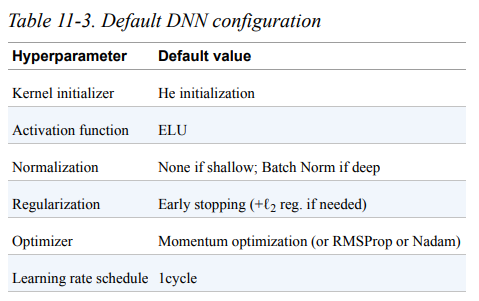

For self-normalizing networks, the following table provides guidelines:

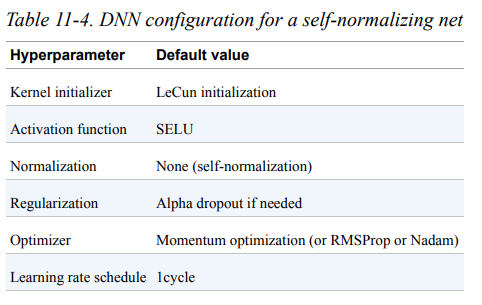

## Exercises

### Question 1

Is it OK to initialize all the weights to the same value as long as
that value is selected randomly using He initialization?

No. Weights cannot be initialized, starting with the same value, even if it is zero. Weights should be initialized independently, with different values. The goal of this is to break symmetry, and allow backpropagation to coverge to a good solution.

Therefore, if the weights, have the same initial value, symmetry is not broken, therefore this will negatively affect the network.

**Lesson: Initailize the weights independently using different values.**

### Question 2

Is it OK to initialize the bias terms to 0?

Yes. You can even initialize the bias in the same manner as the weights

### Question 3

Name three advantages of the SELU activation function over
ReLU

1. SELU can take on negative values, therefore, the average output value of the neurons in any layer is closer to zero. RELU cannot takenot negative values. This ability helps with combatting vanishing gradient issues.


2. SELU has a nonzero-derivative. This helps with issue of dying units that affect RELU units: during training, some neurons
   effectively “die,” meaning they stop outputting anything other than 0
   

3. When the conditions are right (i.e., if the model is
sequential, and the weights are initialized using LeCun
initialization, and the inputs are standardized, and there’s
no incompatible layer or regularization, such as dropout or
ℓ regularization), then the SELU activation function
ensures the model is self-normalized, which solves the
exploding/vanishing gradients problems.


### Question 4

In which cases would you want to use each of the following
activation functions: SELU, leaky ReLU (and its variants), ReLU,
tanh, logistic, and softmax?

**SELU**

The SELU function is a good default to use. SO from now on we gotta use SELU instead of RELU. Also use Lecun initialization for weights initialization.


**RELU and Variants**

If you want to have a fast network, then leaky RELu is your best option.
RELU isused mostly forits simplicity of use, however, it should be noted that SELU outperforms RELU



**Tanh**

Best used in an output layer when predicting between a range -1 and 1. Hardly used in hidden layers.



**Sigmoid**

Used in output layer, especialyy when predicting probabilities. Also hardly used in hidden layers.



**Softmax**

The softmax activation function is useful in the output layer
to output probabilities for mutually exclusive classes, but it is
rarely (if ever) used in hidden layers.

### Question 5

What may happen if you set the `momentum` hyperparameter too
close to 1 (e.g., 0.99999) when using an `SGD` optimizer?

If you set the momentum hyperparameter too close to 1 (e.g.,
0.99999) when using an SGD optimizer, then the algorithm will
likely pick up a lot of speed, hopefully moving roughly toward the
global minimum, but its momentum will carry it right past the
minimum. Then it will slow down and come back, accelerate
again, overshoot again, and so on. It may oscillate this way many
times before converging, so overall it will take much longer to
converge than with a smaller momentum value.

**The model will basically, oscillate about the global minimum and take very long to actually converge on the optimum solution.**

### Question 6

Name three ways you can produce a sparse model.

1. Train the model normally, and then zero out the tiny weights.

2. Use l1 regularization in your hidden layers during training, to add more sparsity.

3. Use the TensorFlow Model Optimization Toolkit.

### Question 7

Does dropout slow down training? Does it slow down inference
(i.e., making predictions on new instances)? What about MC
Dropout?

Yes, dropout does slow down training, in general roughly by a
factor of two. However, it has no impact on inference speed since it
is only turned on during training. MC Dropout is exactly like
dropout during training, but it is still active during inference, so
each inference is slowed down slightly. More importantly, when
using MC Dropout you generally want to run inference 10 times or
more to get better predictions. This means that making predictions
is slowed down by a factor of 10 or more

**So normal dropout slows training down(by factor 2)**,*so essentially training takes 2 times longer give or take*, **but has no effect when making predictions because its off. MCDropout though, does affect makingpredictions, as you want to make 10 predictions or more for better results, thus making predictions takes longer**

### Question 8

Practice training a deep neural network on the CIFAR10 image
dataset:

## a. 

Build a DNN with 20 hidden layers of 100 neurons each
(that’s too many, but it’s the point of this exercise). Use
He initialization and the ELU activation function.

In [2]:
# Get all the libraries we need in order

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *

In [3]:
# Build the model

model = Sequential()

model.add(Flatten(input_shape = [32,32,3]))

#Use a loop to add layers

for _ in range(20):
    model.add(Dense(units = 100, activation = "elu", kernel_initializer = "he_normal"))


## b.

Using Nadam optimization and early stopping, train the
network on the CIFAR10 dataset. You can load it with
keras.datasets.cifar10.load_ data(). The dataset is
composed of 60,000 32 × 32–pixel color images (50,000
for training, 10,000 for testing) with 10 classes, so you’ll
need a softmax output layer with 10 neurons. Remember
to search for the right learning rate each time you change
the model’s architecture or hyperparameters

In [4]:
# Add model output layer

model.add(Dense(units = 10, activation = "softmax"))

#Compile the model and Nadam as an optimizer and an early-stopping callback
model.compile(loss = "sparse_categorical_crossentropy", optimizer = Nadam(learning_rate = 1e-5), metrics = ["accuracy"])

#Load the data from tf.keras.datasets
from tensorflow import keras

(X_train_full, y_train_full), (X_test, y_test) = tensorflow.keras.datasets.cifar10.load_data()

# Split the full training set into training and validation sets

X_train = X_train_full[5000:]
y_train = y_train_full[5000:]
X_valid = X_train_full[:5000]
y_valid = y_train_full[:5000]

#The validdation set has 5k entries, and the training set has 45k entries

#Lets create the callbacks

early_stopping = EarlyStopping(patience = 15, monitor="val_loss", restore_best_weights= True)

# Tensorboard setup
import datetime
from datetime import datetime 
import os

os.makedirs('logs_ch11/fit_ch11', exist_ok=True)
log_dir = "logs_ch11/fit_ch11" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

170500096/170498071 [==============================] - 329s 2us/step


In [7]:
#Finally train the network

history =model.fit(X_train,y_train, epochs=50, validation_data=(X_valid, y_valid), callbacks = [early_stopping],verbose=1)

Epoch 1/50
1407/1407 [==============================] - 23s 16ms/step - loss: 11.2529 - accuracy: 0.1217 - val_loss: 3.2578 - val_accuracy: 0.1400
Epoch 2/50
1407/1407 [==============================] - 23s 16ms/step - loss: 2.7828 - accuracy: 0.1561 - val_loss: 2.4435 - val_accuracy: 0.1706
Epoch 3/50
1407/1407 [==============================] - 24s 17ms/step - loss: 2.3118 - accuracy: 0.1910 - val_loss: 2.1953 - val_accuracy: 0.2128
Epoch 4/50
1407/1407 [==============================] - 23s 16ms/step - loss: 2.1576 - accuracy: 0.2202 - val_loss: 2.0955 - val_accuracy: 0.2382
Epoch 5/50
1407/1407 [==============================] - 23s 16ms/step - loss: 2.0672 - accuracy: 0.2493 - val_loss: 2.0180 - val_accuracy: 0.2620
Epoch 6/50
1407/1407 [==============================] - 23s 16ms/step - loss: 1.9871 - accuracy: 0.2798 - val_loss: 1.9515 - val_accuracy: 0.2924
Epoch 7/50
1407/1407 [==============================] - 23s 16ms/step - loss: 1.9304 - accuracy: 0.2995 - val_loss: 1.9139 

In [ ]:
#View performance on Tensorboard
!rm -rf logs-ch11/fit_ch11

In [ ]:
### Debug training using TensorBoard
%tensorboard --logdir logs_ch11/fit_ch11

In [8]:
# Evaluate the model
model.evaluate(X_valid, y_valid)

157/157 [==============================] - 0s 3ms/step - loss: 1.6332 - accuracy: 0.4224


[1.6331897974014282, 0.42239999771118164]

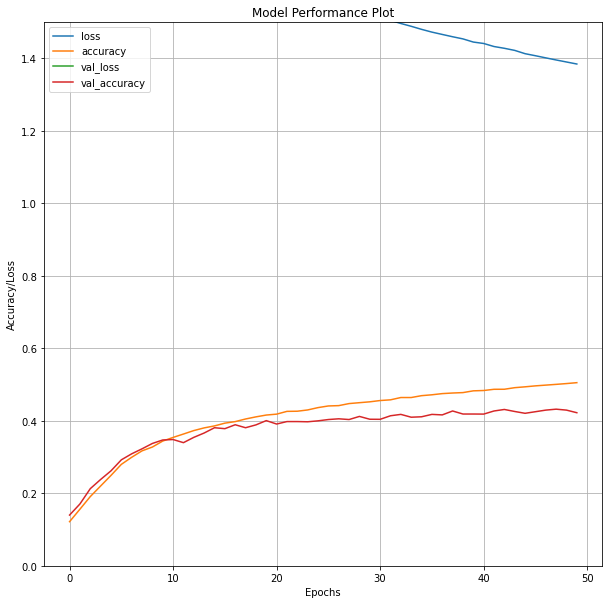

In [10]:
## Visualise the Training Performance
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize = (10, 10))
plt.xlabel("Epochs")
plt.ylabel("Accuracy/Loss")
plt.gca().set_ylim(0, 1.5)
plt.title("Model Performance Plot")
plt.legend()
plt.grid(True)
plt.show()

### Findings and Observations

For a normal NN, that used Nadam optimizer with a learning rate of 1e-5, The validation accuracy was 42.2%. Early Stopping callbacks were incorparated but the training went on for the total number of epochs. The training was conducted at 22s per epoch. There was no learning rate scheduling done. 

To further improve this. Furthertraining would have to be conducted. And further more, a learning rate scheduler would have to be used to find the best lr.

## c. 

Now try adding Batch Normalization and compare the
learning curves: Is it converging faster than before? Does
it produce a better model? How does it affect training
speed?

In [11]:
bn_model = Sequential()
bn_model.add(Flatten(input_shape = [32, 32, 3]))
bn_model.add(BatchNormalization())
for _ in range(20):
    bn_model.add(Dense(units = 100, activation = "elu", kernel_initializer ="he_normal"))
    bn_model.add(BatchNormalization())


    
    
#Add Output Layer
bn_model.add(Dense(units=10, activation="softmax"))

#Compile the model
bn_model.compile(loss = "sparse_categorical_crossentropy", optimizer = Nadam(learning_rate = 5e-4), metrics = ["accuracy"])

In [12]:
#Finally train the network

bn_history =bn_model.fit(X_train,y_train, epochs=50, validation_data=(X_valid, y_valid), callbacks = [early_stopping],verbose=1)

Epoch 1/50
1407/1407 [==============================] - 37s 26ms/step - loss: 1.9248 - accuracy: 0.3106 - val_loss: 1.6892 - val_accuracy: 0.3922
Epoch 2/50
1407/1407 [==============================] - 34s 24ms/step - loss: 1.7123 - accuracy: 0.3870 - val_loss: 1.6087 - val_accuracy: 0.4250
Epoch 3/50
1407/1407 [==============================] - 34s 24ms/step - loss: 1.6405 - accuracy: 0.4148 - val_loss: 1.5320 - val_accuracy: 0.4440
Epoch 4/50
1407/1407 [==============================] - 35s 25ms/step - loss: 1.5828 - accuracy: 0.4368 - val_loss: 1.5513 - val_accuracy: 0.4534
Epoch 5/50
1407/1407 [==============================] - 34s 24ms/step - loss: 1.5448 - accuracy: 0.4524 - val_loss: 1.4737 - val_accuracy: 0.4708
Epoch 6/50
1407/1407 [==============================] - 34s 24ms/step - loss: 1.5054 - accuracy: 0.4656 - val_loss: 1.4715 - val_accuracy: 0.4790
Epoch 7/50
1407/1407 [==============================] - 34s 24ms/step - loss: 1.4637 - accuracy: 0.4818 - val_loss: 1.4255 -

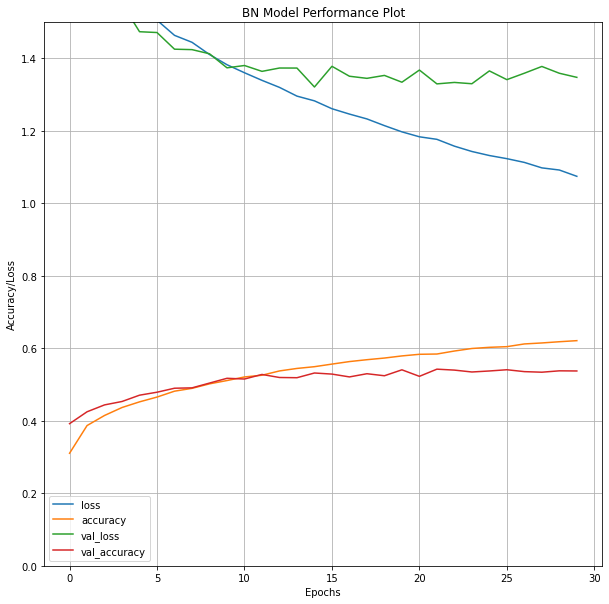

In [13]:
## Visualise the Training Performance
pd.DataFrame(bn_history.history).plot(figsize = (10, 10))
plt.xlabel("Epochs")
plt.ylabel("Accuracy/Loss")
plt.gca().set_ylim(0, 1.5)
plt.title("BN Model Performance Plot")
plt.legend()
plt.grid(True)
plt.show()

In [14]:
# Evaluate the model
bn_model.evaluate(X_valid, y_valid)

157/157 [==============================] - 1s 4ms/step - loss: 1.3212 - accuracy: 0.5320


[1.3211959600448608, 0.5320000052452087]

### Findings and Observations

For a NN, with BatchNormalization, that used Nadam optimizer with a learning rate of 5e-4, The validation accuracy was 53.20%. Early Stopping callbacks were incorparated but the training went on for 30 epochs. The training was conducted at 35s per epoch. There was no learning rate scheduling done. 

This is an improvement from the previous model, where the validation accuracy, from the normal NN, was passed in first 3 epochs. However, the computation time per epoch took longer, as the BN layers added moreoperations to be computed. 

## .d

Try replacing Batch Normalization with SELU, and make
the necessary adjustements to ensure the network selfnormalizes (i.e., standardize the input features, use LeCun
normal initialization, make sure the DNN contains only a
sequence of dense layers, etc.)

In [15]:

sn_model = Sequential()

sn_model.add(Flatten(input_shape = [32,32,3]))

for _ in range(20):
    sn_model.add(Dense(units=100, activation="selu", kernel_initializer="lecun_normal"))

sn_model.add(Dense(units = 10, activation = "softmax"))


#Compile the model
sn_model.compile(loss = "sparse_categorical_crossentropy", optimizer = Nadam(learning_rate = 7e-4), metrics = ["accuracy"])

In [16]:
## Standardise the inputs

#1. You gotta find the mean and std of the training set

X_mean = X_train.mean(axis=0)
X_std = X_train.std(axis=0)

# Formula: X_scaled_i = (Xi -X_mean)/X_std

X_train_scaled = (X_train - X_mean) / X_std
X_valid_scaled = (X_valid - X_mean) / X_std
X_test_scaled =  (X_test - X_mean) / X_std

In [17]:
#Finally train the network

sn_history =sn_model.fit(X_train_scaled, y_train, epochs=50, validation_data=(X_valid_scaled, y_valid), callbacks = [early_stopping],verbose=1)

Epoch 1/50
1407/1407 [==============================] - 38s 27ms/step - loss: 1.9287 - accuracy: 0.3064 - val_loss: 1.8884 - val_accuracy: 0.3174
Epoch 2/50
1407/1407 [==============================] - 31s 22ms/step - loss: 1.7077 - accuracy: 0.3923 - val_loss: 1.7313 - val_accuracy: 0.3906
Epoch 3/50
1407/1407 [==============================] - 32s 23ms/step - loss: 1.6105 - accuracy: 0.4352 - val_loss: 1.6306 - val_accuracy: 0.4240
Epoch 4/50
1407/1407 [==============================] - 32s 23ms/step - loss: 1.5392 - accuracy: 0.4575 - val_loss: 1.6039 - val_accuracy: 0.4406
Epoch 5/50
1407/1407 [==============================] - 30s 22ms/step - loss: 1.4884 - accuracy: 0.4756 - val_loss: 1.5760 - val_accuracy: 0.4498
Epoch 6/50
1407/1407 [==============================] - 30s 21ms/step - loss: 1.4404 - accuracy: 0.4965 - val_loss: 1.5655 - val_accuracy: 0.4444
Epoch 7/50
1407/1407 [==============================] - 30s 22ms/step - loss: 1.3964 - accuracy: 0.5121 - val_loss: 1.5326 -

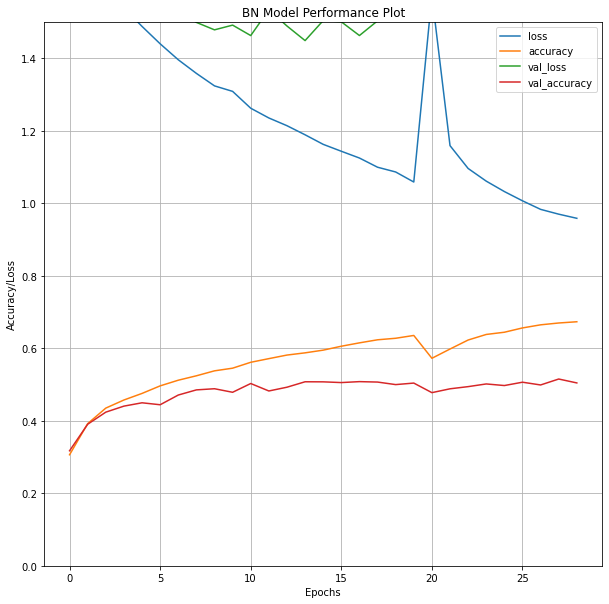

In [18]:
## Visualise the Training Performance
pd.DataFrame(sn_history.history).plot(figsize = (10, 10))
plt.xlabel("Epochs")
plt.ylabel("Accuracy/Loss")
plt.gca().set_ylim(0, 1.5)
plt.title("BN Model Performance Plot")
plt.legend()
plt.grid(True)
plt.show()

In [19]:
# Evaluate the model
sn_model.evaluate(X_valid_scaled, y_valid)

157/157 [==============================] - 0s 3ms/step - loss: 1.4493 - accuracy: 0.5078


[1.4492539167404175, 0.5077999830245972]

### Findings and Observations

For a NN, with self-normalizing characteristics (the output of each layer will tend to preserve a mean of 0 and
standard deviation of 1 during training, which solves the vanishing/exploding gradients problem), that used Nadam optimizer with a learning rate of 7e-4, The validation accuracy was 50.78%. Early Stopping callbacks were incorparated but the training went on for 29 epochs. The training was conducted at 22s per epoch. There was no learning rate scheduling done. 

This is no improvement from the previous BN model,but there is an improvement from the normal NN. However, the computation time per epoch took the same time as the normal NN.

## .e

Try regularizing the model with alpha dropout. Then,
without retraining your model, see if you can achieve
better accuracy using MC Dropout

In [ ]:
model_alphadropout = Sequential()
model_alphadropout.add(Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model_alphadropout.add(Dense(100,
                                 kernel_initializer="lecun_normal",
                                 activation="selu"))

model_alphadropout.add(AlphaDropout(rate=0.1))
model_alphadropout.add(Dense(10, activation="softmax"))

optimizer = Nadam(lr=5e-4)
model_alphadropout.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

In [ ]:
alpha_dropout_history = model_alphadropout.fit(X_train_scaled, y_train, epochs=100,
          validation_data=(X_valid_scaled, y_valid),
          callbacks=[early_stopping])